## Описание задачи:
Стартап запускает новый маркетплейс. Он недавно появился на рынке и занимается продажей новых товаров из Бразилии, которые только начинают поступать в продажу.
1. Необходимо оценить retention.
2. Определить, существует ли product/market fit у этого маркетплейса.
3. Определить 5 основных метрик, на которых продакту можно сконцентрироваться, чтобы максимизировать прибыль компании.
4. Поработать с гипотезами.
5. Сформулировать нужные метрики, на которые гипотеза должна повлиять.

### Описание данных:
1) olist_customers_dataset.csv — таблица с уникальными идентификаторами пользователей.
- customer_id — позаказный идентификатор пользователя.
- customer_unique_id — уникальный идентификатор пользователя.
- customer_zip_code_prefix — почтовый индекс пользователя.
- customer_city — город доставки пользователя.
- customer_state — штат доставки пользователя.

2) olist_orders_dataset.csv —  таблица заказов.
- order_id — уникальный идентификатор заказа.
- customer_id — позаказный идентификатор пользователя.
- order_status — статус заказа.
- order_purchase_timestamp — время создания заказа.
- order_approved_at — время подтверждения оплаты заказа.
- order_delivered_carrier_date — время передачи заказа в логистическую службу.
- order_delivered_customer_date — время доставки заказа.
- order_estimated_delivery_date — обещанная дата доставки.

3) olist_order_items_dataset.csv — товарные позиции, входящие в заказы.
- order_id — уникальный идентификатор заказа.
- order_item_id — идентификатор товара внутри одного заказа.
- product_id — идентификатор товара.
- seller_id — идентификатор производителя товара.
- shipping_limit_date — максимальная дата доставки продавцом для передачи заказа партнеру по логистике.
- price — цена за единицу товара.
- freight_value — вес товара.

### Ход работы:
1. Загрузка данных
2. Когортный анализ
3. product/market fit
4. Выбор 5 основных метрик
5. ICE
6. Выбор метрик, на которые гипотеза должна повлиять
7. Выводы

### 1) Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from operator import attrgetter
import requests
from urllib.parse import urlencode
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
public_keys = [
    'https://disk.yandex.ru/d/YYRsaU1Fy5RiSQ',
    'https://disk.yandex.ru/d/wHpsXAoAbjh47A',
    'https://disk.yandex.ru/d/0nhiZwlHU1Rumg'
]

file_names = [
    'olist_customers_dataset.csv',
    'olist_orders_dataset.csv',
    'olist_order_items_dataset.csv'
]

In [3]:
def download_yandex_disk_files(public_keys, file_names):
    """
    Функция для загрузки публичных файлов из яндекс диска
    """
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    for i in range(len(public_keys)):
        # получаем ссылку для скачивания
        final_url = base_url + urlencode(dict(public_key=public_keys[i]))
        response = requests.get(final_url)
        download_url = response.json()['href']
        
        # скачиваем файл
        download_response = requests.get(download_url)
        with open(file_names[i], 'wb') as f:
            f.write(download_response.content)
        print(f"Файл {file_names[i]} успешно скачан!")

In [4]:
# скачиваем файлы
download_yandex_disk_files(public_keys, file_names)

Файл olist_customers_dataset.csv успешно скачан!
Файл olist_orders_dataset.csv успешно скачан!
Файл olist_order_items_dataset.csv успешно скачан!


In [5]:
# загрузка датасета с уникальными идентификаторами пользователей
customer_df = pd.read_csv('olist_customers_dataset.csv')
# загрузка датасета с заказами
orders_df = pd.read_csv('olist_orders_dataset.csv')
# загрузка датасета с товарными позициями, входящими в заказ
order_items_df = pd.read_csv('olist_order_items_dataset.csv')

### 2) Когортный анализ

In [6]:
# конвертация в дату
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])

In [7]:
# объединение клиентов и заказов
merged_customer_orders = customer_df.merge(orders_df, how='right', on='customer_id')
# оставляем только доставленные заказы
deliv_ord_cust = merged_customer_orders.loc[merged_customer_orders['order_status'] == 'delivered'].copy()

In [8]:
# выделаем из даты подтверждения оплаты заказа месяц и день
deliv_ord_cust['month'] = deliv_ord_cust['order_purchase_timestamp'].dt.to_period('M')
deliv_ord_cust['day'] = deliv_ord_cust['order_purchase_timestamp'].dt.to_period('D')

In [9]:
# присваиваем когорты на основе даты первого действия пользователя
deliv_ord_cust['cohort'] = deliv_ord_cust.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')
deliv_ord_cust['cohort_day'] = deliv_ord_cust.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('D')

In [10]:
# рассчитываем номер периода в днях (месячные периоды / 30)
deliv_ord_cust['period_num_month'] = np.floor((deliv_ord_cust.day - deliv_ord_cust.cohort_day)\
                                              .apply(attrgetter('n')) / 30)

In [11]:
# агрегируем данные по когортам и рассчитанному номеру периода (в месяцах)
df_cohort = deliv_ord_cust.groupby(['cohort', 'period_num_month'])\
                          .agg(n_customers=('customer_unique_id', 'nunique'))\
                          .reset_index()

In [12]:
# создаем новую таблицу для когортного анализа (пивот)
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_num_month', values='n_customers')

In [13]:
# рассчитываем размеры когорты
cohort_size = cohort_pivot.iloc[:, 0]

In [14]:
# вычисляем коэффициент удержания, деля на размер когорты
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

In [15]:
print(f'Когорта с самым высоким retention на 3 месяц: {retention_matrix[3.0].idxmax()}, значение: {retention_matrix[3].max():.4f}%')

Когорта с самым высоким retention на 3 месяц: 2017-01, значение: 0.0056%


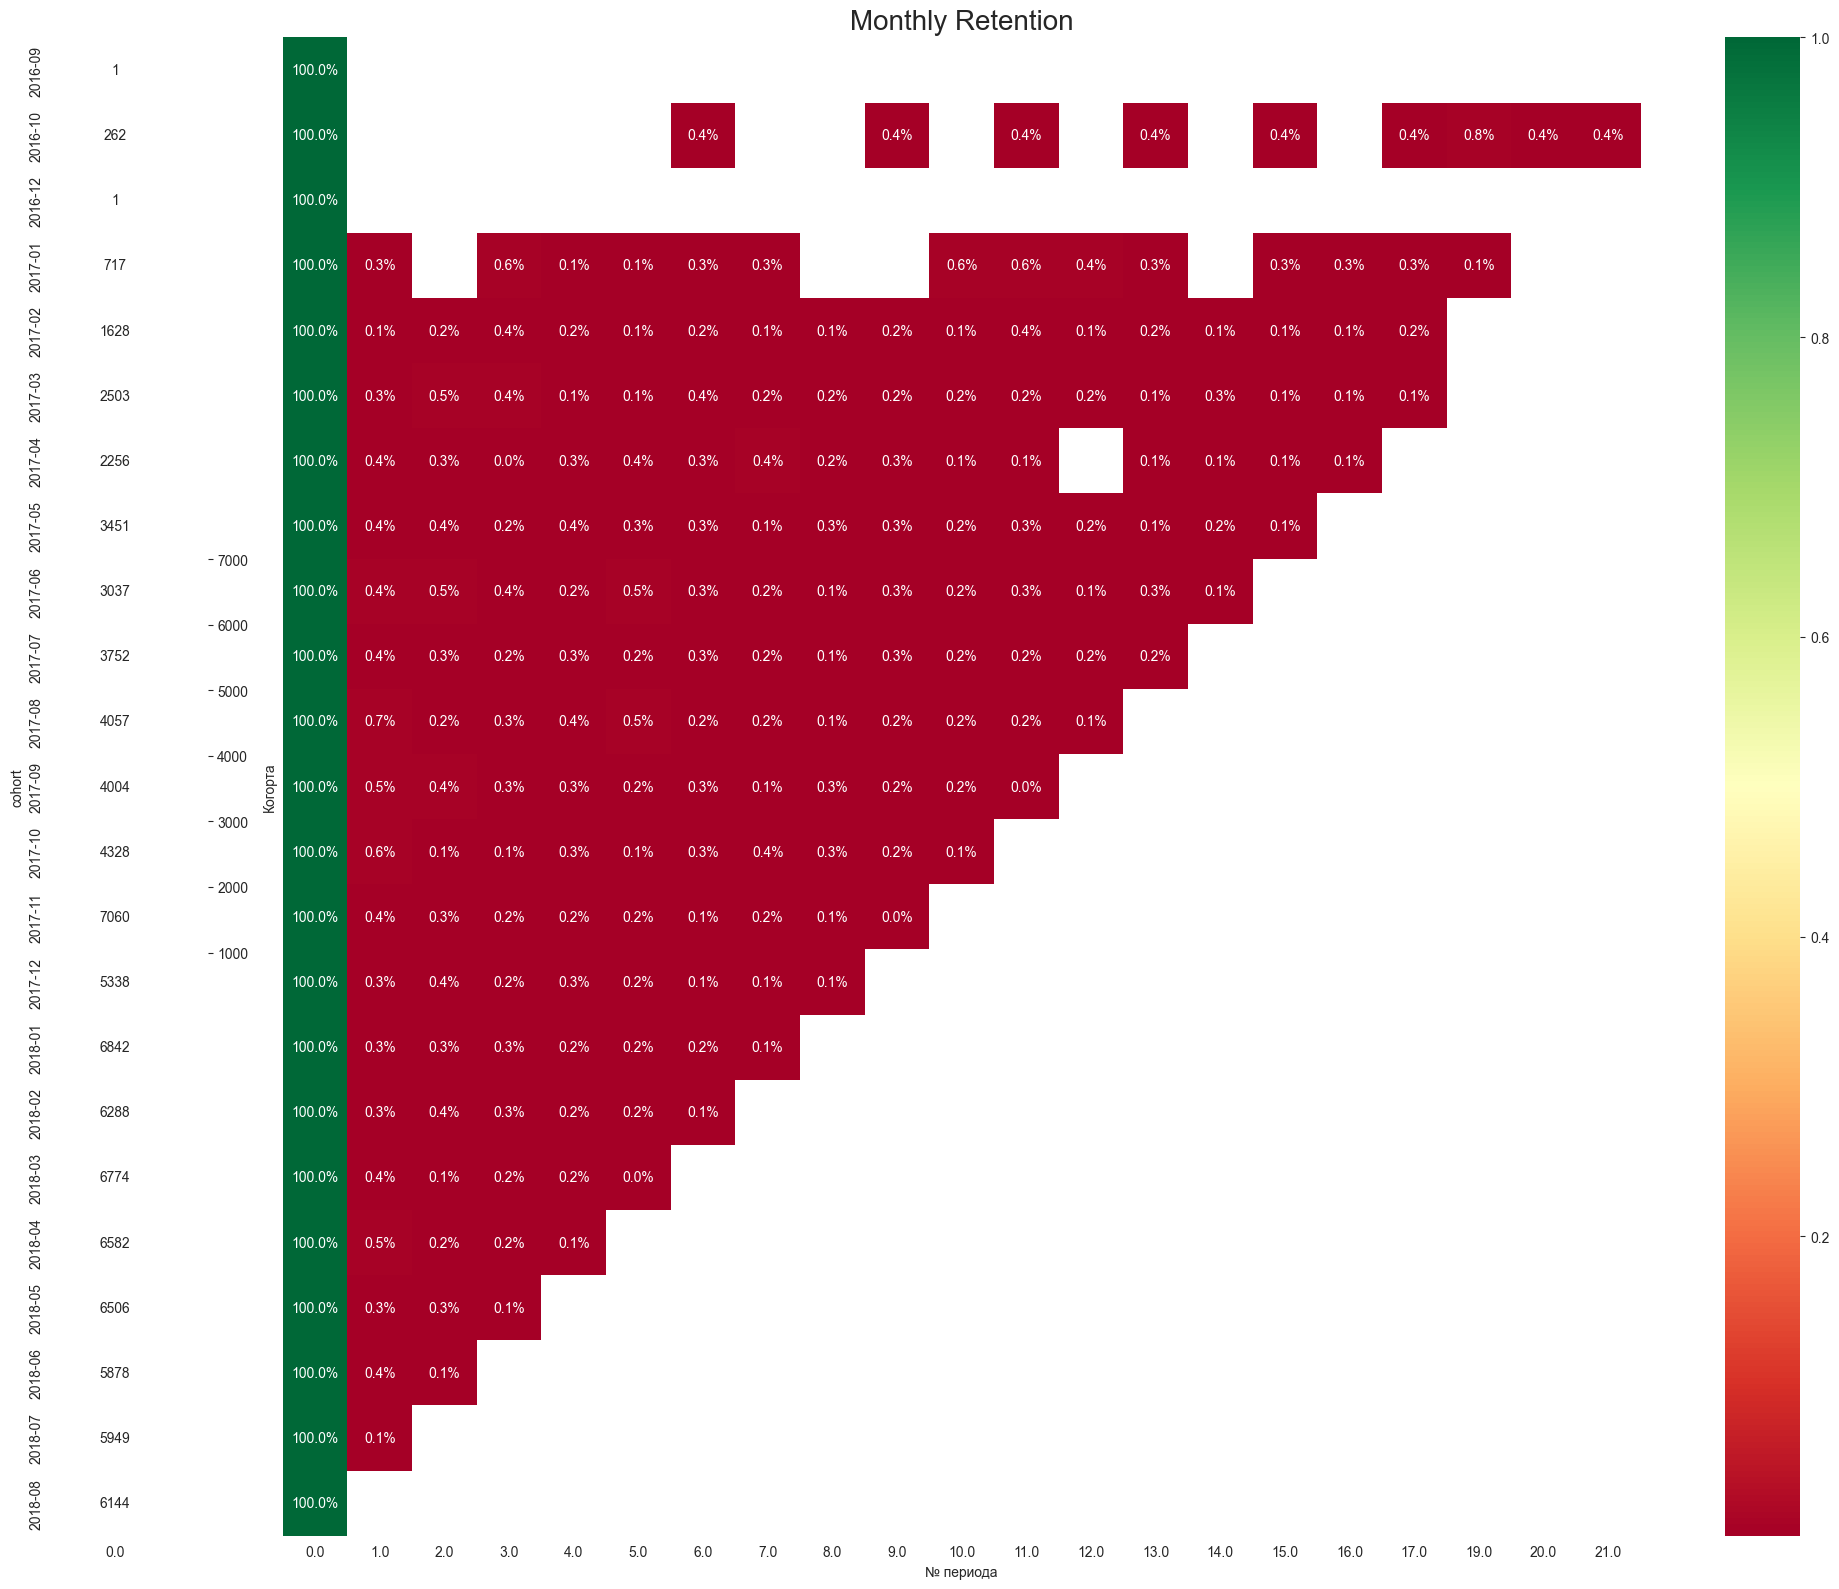

In [16]:
# строим тепловую карту 
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(20, 16), sharey=True, gridspec_kw={'width_ratios' : (1, 11)})
    
    # тепловая карта для коэффициента удержания
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.1%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Monthly Retention', fontsize=20)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')
    
    # тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={'0' : 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])
                               
    fig.tight_layout()
    plt.show()

In [17]:
print(f'Медианный retention за первый месяц: {round(retention_matrix[1.0].median() * 100, 2)}')

Медианный retention за первый месяц: 0.35


### 3) product/market fit

In [18]:
# отток клиентов
churn_rate = (((retention_matrix[0.0] - retention_matrix[1.0]) / retention_matrix[0.0]) * 100).median()
print(f'Медианный churn rate за первый месяц составляет: {round(churn_rate, 2)}')

Медианный churn rate за первый месяц составляет: 99.65


In [19]:
# среднее количество заказов на клиента
mean_cnt_orders_per_client = merged_customer_orders['customer_id'].nunique() / merged_customer_orders['customer_unique_id'].nunique()
print(f'Среднее количество заказов на 1 клиента: {round(mean_cnt_orders_per_client, 2)}')

Среднее количество заказов на 1 клиента: 1.03


In [20]:
# конвертация в дату нужных столбцов
deliv_ord_cust['order_delivered_customer_date'] = pd.to_datetime(deliv_ord_cust['order_delivered_customer_date'])

In [21]:
# среднее время доставки
days_before_delivery = deliv_ord_cust.apply(lambda row: (row['order_delivered_customer_date'] - row['order_purchase_timestamp']).days, axis=1)
mean_days_before_delivery = days_before_delivery.mean()
print(f'Среднее время доставки: {round(mean_days_before_delivery, 2)}')

Среднее время доставки: 12.09


In [22]:
# группировка по статутусу заказа (статус заказа - количество заказов)
order_status_cnt = merged_customer_orders.groupby('order_status', as_index=False)\
                                         .agg({'customer_id' : 'count'})\
                                         .rename(columns={'customer_id' : 'cnt_orders'})

In [23]:
# количество отмененных заказов
cnt_unavailable_orders = order_status_cnt[order_status_cnt['order_status'] == 'unavailable']['cnt_orders'].iloc[0]
cnt_canceled_orders = order_status_cnt[order_status_cnt['order_status'] == 'canceled']['cnt_orders'].iloc[0]
print(f'Количество отмененных заказов: {cnt_canceled_orders}')
print(f'Количество отмененных заказов по причине недоступности товара: {cnt_unavailable_orders}')

Количество отмененных заказов: 625
Количество отмененных заказов по причине недоступности товара: 609


### Вывод о product/market fit:
В соответствии с проведенным выше анализом маркетплейса, можно заключить, что **product/market fit** отсутствует. Что подтверждается следующим:
* **Низкий коэффициет удержания клиентов(retention)**: Медианное значение коэффициента удержания клиентов на первый месяц составляет 0.35%, что отражает низкую возвращаемость клиентов.

* **Высокий коэффициент оттока клиентов (churn rate)**: Медианное значение коэффициента оттока клиентов на первый месяц составляет 99,65% - большинство клиентов не возвращаются повторно на маркетплейс.

* **Низкая частота покупок**: Среднее количество заказов на 1 клиента составляет 1.03, из чего может следовать, что большинство клиентов совершают один заказ и не возвращаются (что понятно исходя из метрик, приведенных выше).

* **Количество отмененных заказов**: 625, что может быть связано с долгой доставкой, ошибками при оформлении заказов и т.д. Также, есть ряд товаров, отмененных по причине недоступности товара - 609 (может служить основанием для оттока клиентов). Возможно, стоит улучшить процессы управления запасами.

* **Высокое время доставки**: среднее время доставки составляет 12 дней. Возможно, это вызывает недовольство у клиентов и они не возвращаются для повторного заказа в маркетплейс.

### 4) Выбор 5 основных метрик

#### Первая метрика. Рост объема продаж маркетплейса отражает GMV (общая стоимость товаров, проданных через маркетплейс)

In [24]:
price_orders = order_items_df.groupby('order_id', as_index=False)['price'].sum()  # итоговая сумма для каждого заказа

In [25]:
# объединяем данные об итоговой сумме заказа с информацией о доставленных заказах
orders_price_cust = deliv_ord_cust.merge(price_orders, how='left', on='order_id') 

In [26]:
# общая стоимость товаров, проданных через маркетплейс
gmv_df = orders_price_cust.groupby('month', as_index=False)['price'].sum().rename(columns={'price' : 'gmv'})

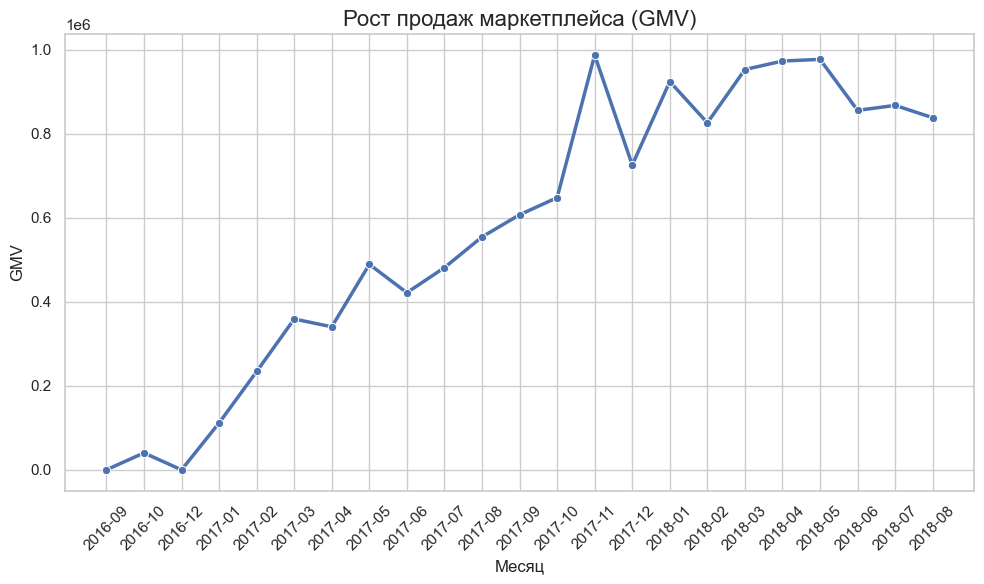

In [27]:
sns.set_theme(style="whitegrid")

# линейный график
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=gmv_df, 
    x=gmv_df['month'].astype(str), 
    y='gmv',
    marker='o',  
    linewidth=2.5 
)

# настройка заголовка и подписей осей
ax.set_title('Рост продаж маркетплейса (GMV)', fontsize=16)
ax.set_xlabel('Месяц', fontsize=12)
ax.set_ylabel('GMV', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

#### Вторая метрика. Объем аудитории, которой продукт доставляет ценность отражаект Paying Users (количество платящих клиентов)

In [28]:
paying_users = deliv_ord_cust.groupby('month')['customer_unique_id'].nunique()
paying_users = pd.DataFrame({'month' : paying_users.index, 'paying_users' : paying_users.values})

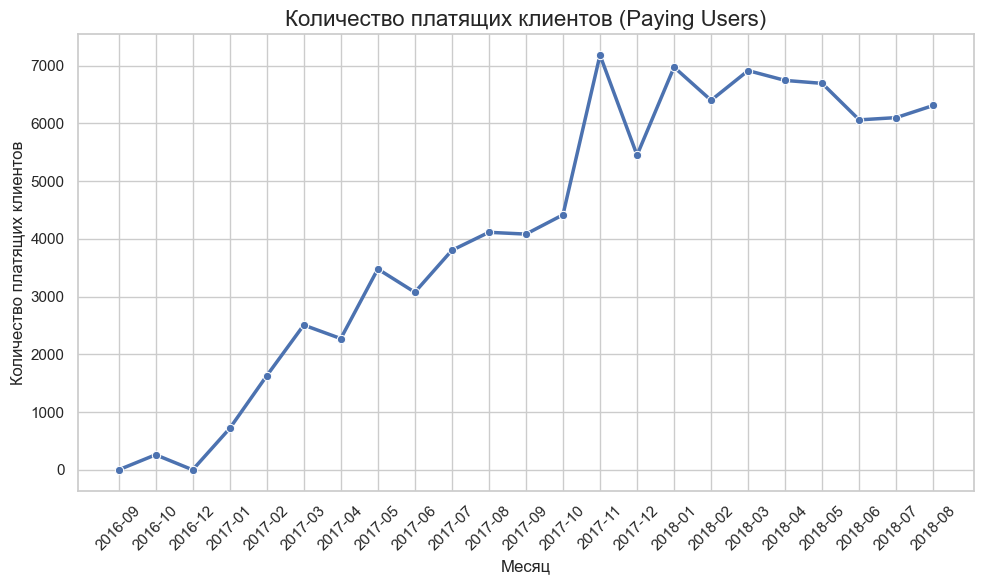

In [29]:
sns.set_theme(style="whitegrid")

# линейный график
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=paying_users, 
    x=paying_users['month'].astype(str), 
    y='paying_users',
    marker='o',  
    linewidth=2.5 
)

# настройка заголовка и подписей осей
ax.set_title('Количество платящих клиентов (Paying Users)', fontsize=16)
ax.set_xlabel('Месяц', fontsize=12)
ax.set_ylabel('Количество платящих клиентов', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

#### 3-4 метрики 
Третья метрика. Заинтересованность новых клиентов в продакте отражает CR (конверсия в покупку на маркетплейсе).

Четвертая метрика. Вовлеченность клиентьа в продолжение использования продукта - retention (рассчитана выше).

#### Пятая метрика. Денежное выражение вовлеченности клиента - ARPPU (общая выручка, которая компания получает с одного клиента в среднем).

In [30]:
# расчет ARPPU
arppu_df = orders_price_cust.groupby('month')['price'].sum() / orders_price_cust.groupby('month')['customer_unique_id'].nunique()
arppu_df = pd.DataFrame({'month' : arppu_df.index, 'arppu' : arppu_df.values})

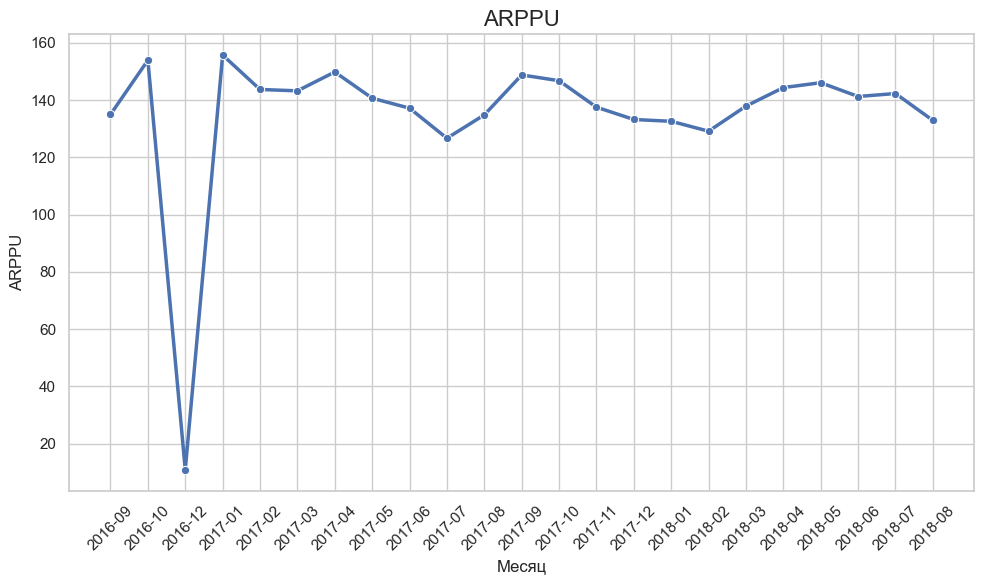

In [31]:
sns.set_theme(style="whitegrid")

# линейный график
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=arppu_df, 
    x=arppu_df['month'].astype(str), 
    y='arppu',
    marker='o',  
    linewidth=2.5 
)

# настройка заголовка и подписей осей
ax.set_title('ARPPU', fontsize=16)
ax.set_xlabel('Месяц', fontsize=12)
ax.set_ylabel('ARPPU', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

### Вывод по метрикам

Определены 5 основных метрик:
1. В качестве метрики, отражающей рост объема продаж, выбрана **GMV** (общая стоимость товаров, проданных через маркетплейс). Рост GMV неравномерный, последние 2 месяца наблюдается спад.
2. Метрика для отражения объема аудитории, которое маркетплейс предоставляет ценность - **Paying users** (количество платящих пользователей). Динамика схожа с динамикой GMV.
3. Заинтересованность новых клиентов в продакте отражает метрика **CR** (конверсия в первую покупку на маркетплейсе). 
4. Вовлеченность клиентов в продолжение использование продукта отражает **retention**. Удержание клиентов является основной проблемой маркетплейса (медианный retention 0.35% на первый месяц).
5. В качестве денежного выражения вовлеченности клиента может выступать **ARPPU** (общая выручка, которая компания получает с одного клиента в среднем). Динамика ARPU демострирует падение, клиенты тратят меньше. 

### 5) ICE

#### Проверка первой гипотезы

Гипотеза: Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен.

In [32]:
# данные о клиентах и заказах с июня 2017 года
customer_orders = merged_customer_orders.copy()
customer_orders['order_approved_at'] = pd.to_datetime(customer_orders['order_approved_at'])
customer_orders['month'] = customer_orders['order_approved_at'].dt.to_period('M')
customer_orders_2017_06 = customer_orders.loc[customer_orders['month'] >= '2017-06']

In [33]:
# количество отмененных заказов
cnt_calceled_orders_hyp = len(customer_orders_2017_06.loc[customer_orders_2017_06['order_status'] == 'canceled'])

In [34]:
# impact для первой гипотезы 
impact_1 = cnt_calceled_orders_hyp 

#### Проверка второй гипотезы

Гипотеза: Если сократим время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных заказов.

In [35]:
# формат даты
deliv_ord_cust['order_estimated_delivery_date'] = pd.to_datetime(deliv_ord_cust['order_delivered_customer_date'])

In [36]:
# заказы, где доставка была с задержкой (True - если задержка)
orders_late = deliv_ord_cust[deliv_ord_cust['month'] >= '2017-06'].apply(lambda row:
                                                                         True if row['order_estimated_delivery_date'] <
                                                                         row['order_delivered_customer_date'] else False,
                                                                         axis=1)

In [37]:
# impact для второй гипотезы 
impact_2 = orders_late.sum() * retention_matrix[1.0].median()

#### Проверка третьей гипотезы

Гипотеза: Если создадим новый способ оплаты, который будет конвертировать клиентов в повторный заказ, то клиенты не будут испытывать трудности при оформлении заказа, вследствие чего количество заказов увеличится за счёт повторных заказов.

In [38]:
# общее количество заказов за период
total_cnt_orders = customer_orders_2017_06.order_id.nunique()

In [39]:
# impact для третьей гипотезы
impact_3 = total_cnt_orders * retention_matrix[1.0].median()

#### Перевод Impact в шкалу, работа с показателями ICE

In [40]:
def scale_impact(value):
    """
        Функция для перевода метрики в impact по шкале.
    """
    if 0 <= value <= 50:
        impact = 1
    elif 51 <= value <= 150:
        impact = 2
    elif 151 <= value <= 350:
        impact = 3
    elif 351 <= value <= 750:
        impact = 4
    elif 751 <= value <= 1550:
        impact = 5
    elif 1551 <= value <= 3150:
        impact = 6
    elif 3151 <= value <= 6350:
        impact = 7
    elif 6351 <= value <= 12750:
        impact = 8
    elif 12751 <= value <= 25550:
        impact = 9
    elif 25551 <= value <= 51150:
        impact = 10
    
    return impact

In [41]:
# создание датафрейма с исходными данными
number_hyp = list(range(1, 4))
confidence_list = [8, 10, 5]
ease_list = [6, 4, 9]
impact_list = [impact_1, impact_2, impact_3]

df_ice = pd.DataFrame({'hypothesis' : number_hyp, 'confidence' : confidence_list, 
                       'ease' : ease_list, 'impact' : impact_list})

In [42]:
# конвертируем метрики в impact
df_ice['impact'] = df_ice.impact.apply(scale_impact)

In [43]:
# рассчитываем ICE
df_ice['ICE'] = df_ice.impact * df_ice.confidence * df_ice.ease

In [44]:
# сортируем по ICE и оставляем лучшую гипотезу
df_ice.sort_values(by='ICE', ascending=False).head(1)

,hypothesis,confidence,ease,impact,ICE
0,1,8,6,4,192


#### Вывод по выбору гипотезы
В соответствии с проведенным анализом, лучшей гипотезой является первая - "Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен."

####  5) Нужные метрики, на которые гипотеза должна повлиять

Гипотеза должна повлиять на следующие метрики: а)количество заказов, б)конверсия в доставку, в)конверсия в оформление заказа.

Целевые метрики: 

1. Количество заказов
- Определение: общее количество заказов, которые были успешно доставлены клиентам.
- Цель: оценить, увеличилось ли количество успешных доставок после исправления бага.

Прокси метрики:

1. Конверсия в доставку товара до покупателя
- Определение: общее количество заказов, которые были доставлены клиентам / общее количество заказов.
- Цель: измерить снижение числа отмен после исправления бага.

Барьерные метрики:

1. Конверсия в оформление заказа

- Определение: доля клиентов, которые оформили заказ, деленная на количество активной аудитории.

- Цель: убедиться, что исправление бага не негативно сказалось на общем восприятии клиента совершить следующий заказ.

## Общий вывод о проделанной работе

#### Формализация проблемы продукта

Маркетплейс столкнулся с проблемой стагнации выручки. Несмотря на наличие пользователей и определенный товарный ассортимент, продукт не достигает необходимого уровня роста и не удовлетворяет запросы клиентов.

В связи с чем, была проделана следующая работа:

#### Оценка месячного retention в оформление заказа

В ходе анализа был выявлен низкий коэффициент удержания клиентов (retention), медианное значение которого на 1-й месяц составляет 0.35%. Самый высокий retention на 3-й месяц в когорте января 2017 года и составляет 0.59%. Приведенные данные отражают низкую возвращаемость клиентов на маркетплейс.


#### Определение product/market fit

В соответствии с проведенным анализом маркетплейса, можно заключить, что **product/market fit** отсутствует. Что подтверждается следующим:

1.	Низкий коэффициет удержания клиентов(retention).
2.	Высокий коэффициент оттока клиентов (churn rate): Медианное значение коэффициента оттока клиентов на первый месяц составляет 99,65% - большинство клиентов не возвращаются повторно на маркетплейс.
3.	Низкая частота покупок: Среднее количество заказов на 1 клиента составляет 1.03, из чего может следовать, что большинство клиентов совершают один заказ и не возвращаются (что понятно исходя из метрик, приведенных выше).
4.	Количество отмененных заказов: 625, что может быть связано с долгой доставкой, ошибками при оформлении заказов и т.д. Также, есть ряд товаров, отмененных по причине недоступности - 609 (может служить основанием для оттока клиентов). Возможно, стоит улучшить процессы управления запасами.
5.	Высокое время доставки: Среднее время доставки составляет 12 дней. Возможно, это вызывает недовольство у клиентов и они не возвращаются для повторного заказа на маркетплейс.


#### Определение 5 метрик, на которых необходимо сконцентироваться для максимизации прибыли компании

Необходимо сосредоточиться на следующих метриках:

 1. В качестве метрики, отражающей рост объема продаж, выбрана GMV (общая стоимость товаров, проданных через маркетплейс). Рост GMV неравномерный, последние 2 месяца наблюдается спад.
 2. Метрика для отражения объема аудитории, которой маркетплейс предоставляет ценность - Paying users (количество платящих клиентов). Динамика схожа с динамикой GMV.
3.	Заинтересованность новых клиентов в продакте отражает метрика CR (конверсия в покупку на маркетплейсе).
4.	Вовлеченность клиентов в продолжение использование продукта отражает retention. Удержание клиентов является основной проблемой маркетплейса (медианный retention 0.35% на первый месяц).
5.	В качестве денежного выражения вовлеченности клиента может выступать ARPPU (общая выручка, которая компания получает с одного клиента в среднем). Динамика ARPPU демострирует падение, клиенты тратят меньше.

#### Выбор гипотезы с помощью фреймворка ICE

В соответствии с проведенным анализом, лучшей гипотезой является первая - "Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен."


#### Метрики, на которые гипотеза должна повлиять

Гипотеза должна повлиять на следующие метрики: а)количество заказов, б)конверсия в доставку, в)конверсия в оформление заказа.

Целевые метрики: 
    1. Количество заказов
    Определение: общее количество заказов, которые были успешно доставлены клиентам.
    Цель: оценить, увеличилось ли количество успешных доставок после исправления бага.
Прокси метрики:
    2. Конверсия в доставку товара до покупателя
    Определение: общее количество заказов, которые были доставлены клиентам / общее количество заказов.
    Цель: измерить снижение числа отмен после исправления бага.
Барьерные метрики:
    3. Конверсия в оформление заказа
    Определение: доля клиентов, которые оформили заказ, деленная на количество активной аудитории.
    Цель: убедиться, что исправление бага не негативно сказалось на общем восприятии клиента совершить следующий заказ.
    
    
#### Общие выводы по итогу исследования

Проведенное исследование позволило выявить ключевые проблемы маркетплейса, связанные с низким удержанием клиентов, высоким количеством отмен заказов и долгим сроком доставки. Эти факторы отрицательно влияют на такие ключевые метрики, как объем продаж (GMV), средний доход на одного пользователя (ARPPU) и количество платящих пользователей (Paying users), что в результате приводит к стагнации выручки.

Основной проблемой является отсутствие product/market fit, что подтверждается низким коэффициентов удержания клиентов (retention). Кроме того, значительно количество отмен и длительное время доставки могут быть основными причинами неудовлетворенности клиентов. 

В ходе исследования были определены 5 ключевых метрик, на которых следует сфокусироваться для улучшения ситуации: GMV, Paying users, CR, retention, ARPPU.

Анализ гипотез по фреймворку ICE позволил выделить наиболее приоритетное направление — исправление багов в системе процессинга заказов, что должно снизить процент отмен и увеличить долю успешно доставленных заказов. Ожидаемый эффект: рост количества заказов, конверсии в доставку.

Таким образом, маркетплейсу необходимо сосредоточиться на улучшении системы процессинга заказов, логистических процессов, сокращении времени доставки и устранении отмен. Данные рекомендации позволят повысить удовлетворенность клиентов, снизить отток и в результате стимулировать рост ключевых метрик. 